# URDB Tariff Viewer and Visualizer

This notebook loads and visualizes utility rate tariffs from the URDB JSON format. The default example uses the LADWP A-3 tariff.

## Import Required Libraries

Let's import the necessary Python libraries for data analysis and visualization:

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from copy import deepcopy

# Initialize Jupyter widgets
try:
    from IPython.display import display_html
    display_html("""
        <script>
            if (typeof require !== 'undefined') {
                require.config({
                    paths: {
                        'jupyter-js-widgets': 'nbextensions/jupyter-js-widgets/extension'
                    }
                });
                require(['jupyter-js-widgets'], function(widgets) {
                    console.log('Widgets loaded');
                });
            }
        </script>
        """, raw=True)
except:
    print("Note: For full widget support, please ensure ipywidgets is installed:")
    print("pip install ipywidgets")
    print("jupyter nbextension enable --py widgetsnbextension")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_theme()

## Widget Setup Note

If you see widget-related errors, please run these commands in your terminal to set up widget support:

```bash
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Then restart your Jupyter kernel and try running the notebook again.

## Load and Parse URDB JSON Data

Load the LADWP A-3 tariff data from the JSON file:

In [2]:
# Load JSON data
with open('LADWP_A-3.json', 'r') as file:
    data = json.load(file)

# Get the first (and only) tariff item
tariff = data['items'][0]

# Extract basic information
utility_name = tariff['utility']
rate_name = tariff['name']
sector = tariff['sector']
description = tariff['description']

## Extract Rate Schedules

Now let's extract and process the energy rate schedules for both weekdays and weekends:

In [3]:
# Function to convert rate period to actual rate
def get_rate(period_index, rate_structure):
    if period_index < len(rate_structure):
        rate = rate_structure[period_index][0]['rate']
        adj = rate_structure[period_index][0].get('adj', 0)
        return rate + adj
    return 0

# Get rate structures
energy_rates = tariff['energyratestructure']
weekday_schedule = tariff['energyweekdayschedule']
weekend_schedule = tariff['energyweekendschedule']

# Convert schedules to DataFrames
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours = list(range(24))

# Create weekday rates DataFrame
weekday_rates = []
for month_schedule in weekday_schedule:
    rates = [get_rate(period, energy_rates) for period in month_schedule]
    weekday_rates.append(rates)
    
weekday_df = pd.DataFrame(weekday_rates, index=months, columns=hours)

# Create weekend rates DataFrame
weekend_rates = []
for month_schedule in weekend_schedule:
    rates = [get_rate(period, energy_rates) for period in month_schedule]
    weekend_rates.append(rates)
    
weekend_df = pd.DataFrame(weekend_rates, index=months, columns=hours)

In [4]:
class TariffEditor:
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            self.data = json.load(file)
        self.tariff = self.data['items'][0]
        self.original_tariff = deepcopy(self.tariff)
        
        # Extract basic information
        self.utility_name = self.tariff['utility']
        self.rate_name = self.tariff['name']
        self.sector = self.tariff['sector']
        self.description = self.tariff['description']
        
        # Setup data structures
        self.months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        self.hours = list(range(24))
        self.weekday_df = None
        self.weekend_df = None
        self.selected_month = 0
        self.selected_hour = 0
        self.is_weekday = True
        
        # Create widgets
        self.create_widgets()
        self.update_rate_dataframes()
        
    def get_rate(self, period_index, rate_structure):
        if period_index < len(rate_structure):
            rate = rate_structure[period_index][0]['rate']
            adj = rate_structure[period_index][0].get('adj', 0)
            return rate + adj
        return 0
    
    def update_rate_dataframes(self):
        energy_rates = self.tariff['energyratestructure']
        weekday_schedule = self.tariff['energyweekdayschedule']
        weekend_schedule = self.tariff['energyweekendschedule']
        
        # Create weekday rates DataFrame
        weekday_rates = []
        for month_schedule in weekday_schedule:
            rates = [self.get_rate(period, energy_rates) for period in month_schedule]
            weekday_rates.append(rates)
        self.weekday_df = pd.DataFrame(weekday_rates, index=self.months, columns=self.hours)
        
        # Create weekend rates DataFrame
        weekend_rates = []
        for month_schedule in weekend_schedule:
            rates = [self.get_rate(period, energy_rates) for period in month_schedule]
            weekend_rates.append(rates)
        self.weekend_df = pd.DataFrame(weekend_rates, index=self.months, columns=self.hours)
    
    def create_widgets(self):
        self.month_dropdown = widgets.Dropdown(
            options=list(enumerate(self.months)),
            description='Month:',
            style={'description_width': 'initial'}
        )
        
        self.hour_dropdown = widgets.Dropdown(
            options=[(f'{h:02d}:00', h) for h in self.hours],
            description='Hour:',
            style={'description_width': 'initial'}
        )
        
        self.day_type = widgets.ToggleButtons(
            options=['Weekday', 'Weekend'],
            description='Day type:',
            style={'description_width': 'initial'}
        )
        
        self.rate_input = widgets.FloatText(
            description='Rate ($/kWh):',
            style={'description_width': 'initial'}
        )
        
        self.update_button = widgets.Button(
            description='Update Rate',
            style={'description_width': 'initial'}
        )
        
        self.save_button = widgets.Button(
            description='Save Changes',
            style={'description_width': 'initial',
                   'button_color': 'lightgreen'}
        )
        
        self.reset_button = widgets.Button(
            description='Reset Changes',
            style={'description_width': 'initial',
                   'button_color': 'lightcoral'}
        )
        
        # Set up callbacks
        self.update_button.on_click(self.update_rate)
        self.save_button.on_click(self.save_changes)
        self.reset_button.on_click(self.reset_changes)
        self.day_type.observe(self.update_current_rate, names='value')
        self.month_dropdown.observe(self.update_current_rate, names='value')
        self.hour_dropdown.observe(self.update_current_rate, names='value')
        
    def update_current_rate(self, change=None):
        month_idx = self.month_dropdown.value
        hour = self.hour_dropdown.value
        is_weekday = self.day_type.value == 'Weekday'
        
        df = self.weekday_df if is_weekday else self.weekend_df
        current_rate = df.iloc[month_idx, hour]
        self.rate_input.value = current_rate
        
    def update_rate(self, b):
        month_idx = self.month_dropdown.value
        hour = self.hour_dropdown.value
        is_weekday = self.day_type.value == 'Weekday'
        new_rate = self.rate_input.value
        
        # Update the appropriate schedule and rate structure
        schedule_key = 'energyweekdayschedule' if is_weekday else 'energyweekendschedule'
        period_idx = self.tariff[schedule_key][month_idx][hour]
        
        # Update the rate in the rate structure
        self.tariff['energyratestructure'][period_idx][0]['rate'] = new_rate
        
        # Update dataframes and display
        self.update_rate_dataframes()
        self.display_visualizations()
        
    def save_changes(self, b):
        with open('LADWP_A-3_modified.json', 'w') as f:
            json.dump(self.data, f, indent=2)
        display(HTML('<p style="color: green;">Changes saved to LADWP_A-3_modified.json</p>'))
        
    def reset_changes(self, b):
        self.tariff = deepcopy(self.original_tariff)
        self.data['items'][0] = self.tariff
        self.update_rate_dataframes()
        self.update_current_rate()
        self.display_visualizations()
        display(HTML('<p style="color: blue;">Rates reset to original values</p>'))
    
    def display_visualizations(self):
        clear_output(wait=True)
        
        # Display widgets
        controls = widgets.VBox([
            widgets.HBox([self.month_dropdown, self.hour_dropdown, self.day_type]),
            widgets.HBox([self.rate_input, self.update_button]),
            widgets.HBox([self.save_button, self.reset_button])
        ])
        display(controls)
        
        # Create weekday heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(self.weekday_df, annot=True, fmt='.3f', cmap='YlOrRd',
                   xticklabels=[f'{h}:00' for h in self.hours],
                   yticklabels=self.months,
                   cbar_kws={'label': '$/kWh'},
                   linewidths=0.5, linecolor='gray')
        plt.title(f'Weekday Energy Rates - {self.utility_name} {self.rate_name}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Month')
        plt.tight_layout()
        plt.show()
        
        # Create weekend heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(self.weekend_df, annot=True, fmt='.3f', cmap='YlOrRd',
                   xticklabels=[f'{h}:00' for h in self.hours],
                   yticklabels=self.months,
                   cbar_kws={'label': '$/kWh'},
                   linewidths=0.5, linecolor='gray')
        plt.title(f'Weekend Energy Rates - {self.utility_name} {self.rate_name}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Month')
        plt.tight_layout()
        plt.show()
        
        # Display tariff details
        details = f"""
        <table style="width:100%">
            <tr>
                <th colspan="2" style="text-align:left; background-color:#f0f0f0; padding:10px">Tariff Information</th>
            </tr>
            <tr>
                <td style="width:30%; padding:5px"><b>Utility Name:</b></td>
                <td style="padding:5px">{self.utility_name}</td>
            </tr>
            <tr>
                <td style="padding:5px"><b>Rate Name:</b></td>
                <td style="padding:5px">{self.rate_name}</td>
            </tr>
            <tr>
                <td style="padding:5px"><b>Sector:</b></td>
                <td style="padding:5px">{self.sector}</td>
            </tr>
            <tr>
                <td style="padding:5px"><b>Minimum Demand:</b></td>
                <td style="padding:5px">{self.tariff.get('peakkwcapacitymin', 'N/A')} kW</td>
            </tr>
            <tr>
                <td style="padding:5px"><b>Fixed Monthly Charge:</b></td>
                <td style="padding:5px">${self.tariff.get('fixedchargefirstmeter', 'N/A')}</td>
            </tr>
        </table>

        <table style="width:100%; margin-top:20px">
            <tr>
                <th colspan="2" style="text-align:left; background-color:#f0f0f0; padding:10px">Description</th>
            </tr>
            <tr>
                <td style="padding:5px">{self.description}</td>
            </tr>
        </table>
        """
        display(HTML(details))

## Interactive Tariff Editor

Create an interactive editor instance and display it:

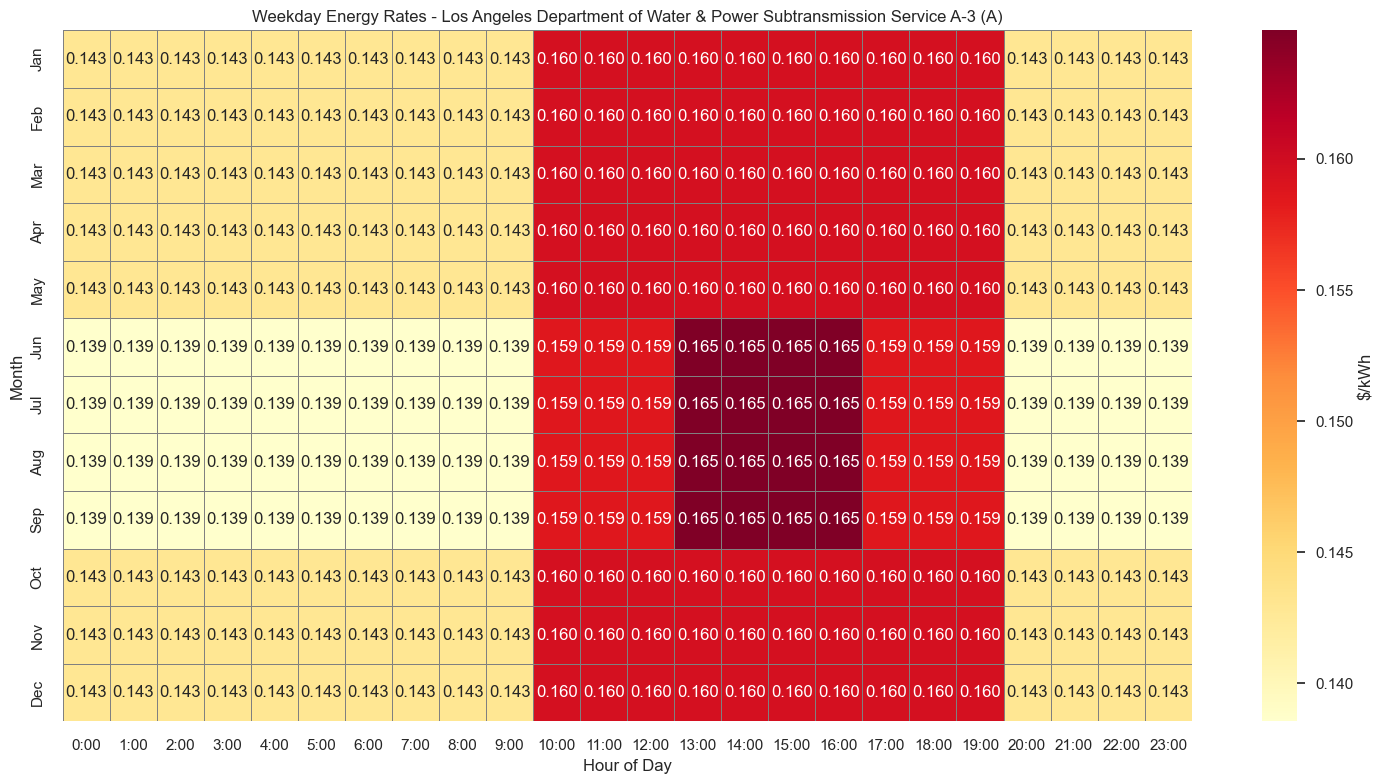

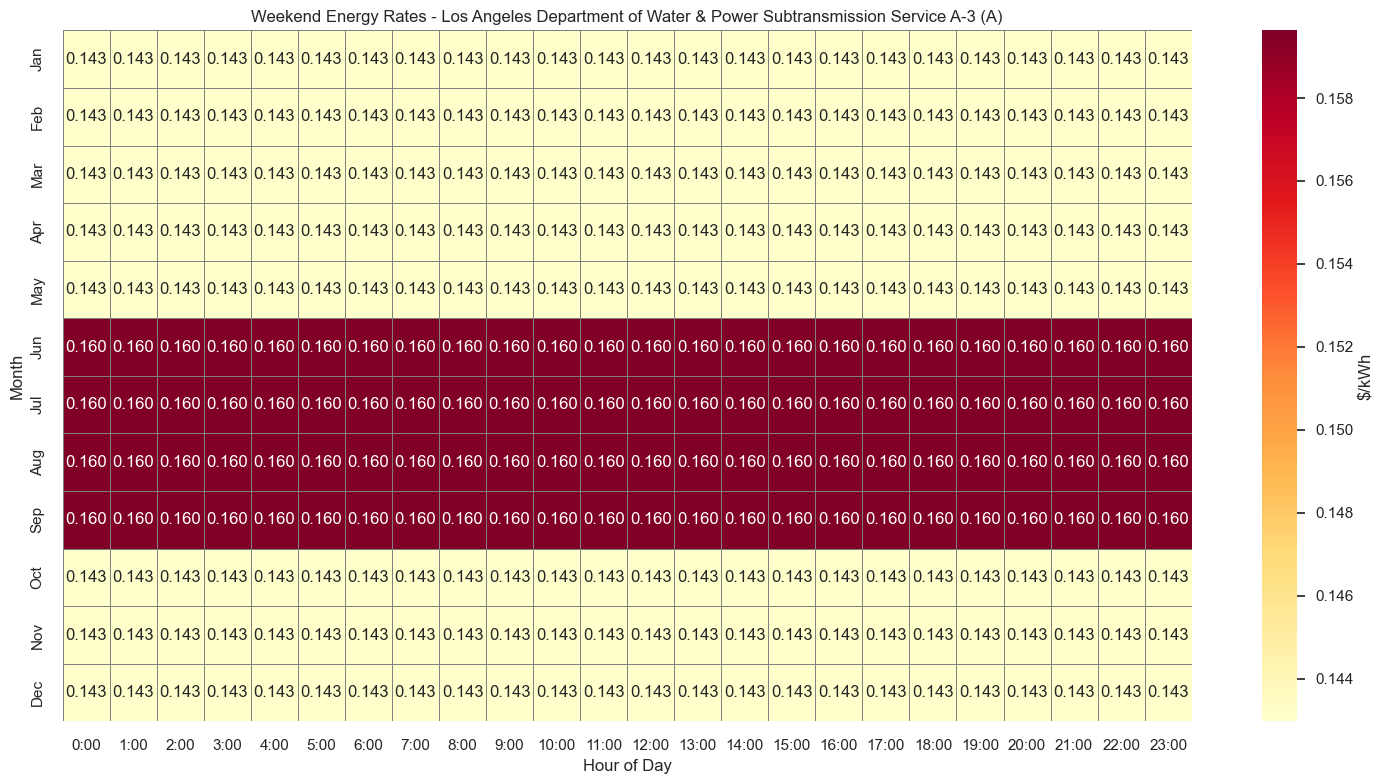

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [5]:
# Create the tariff editor
editor = TariffEditor('LADWP_A-3.json')

# Display the interactive interface
editor.display_visualizations()

## Create Weekday Rate Visualization

Create a heatmap showing the energy rates by hour and month for weekdays:

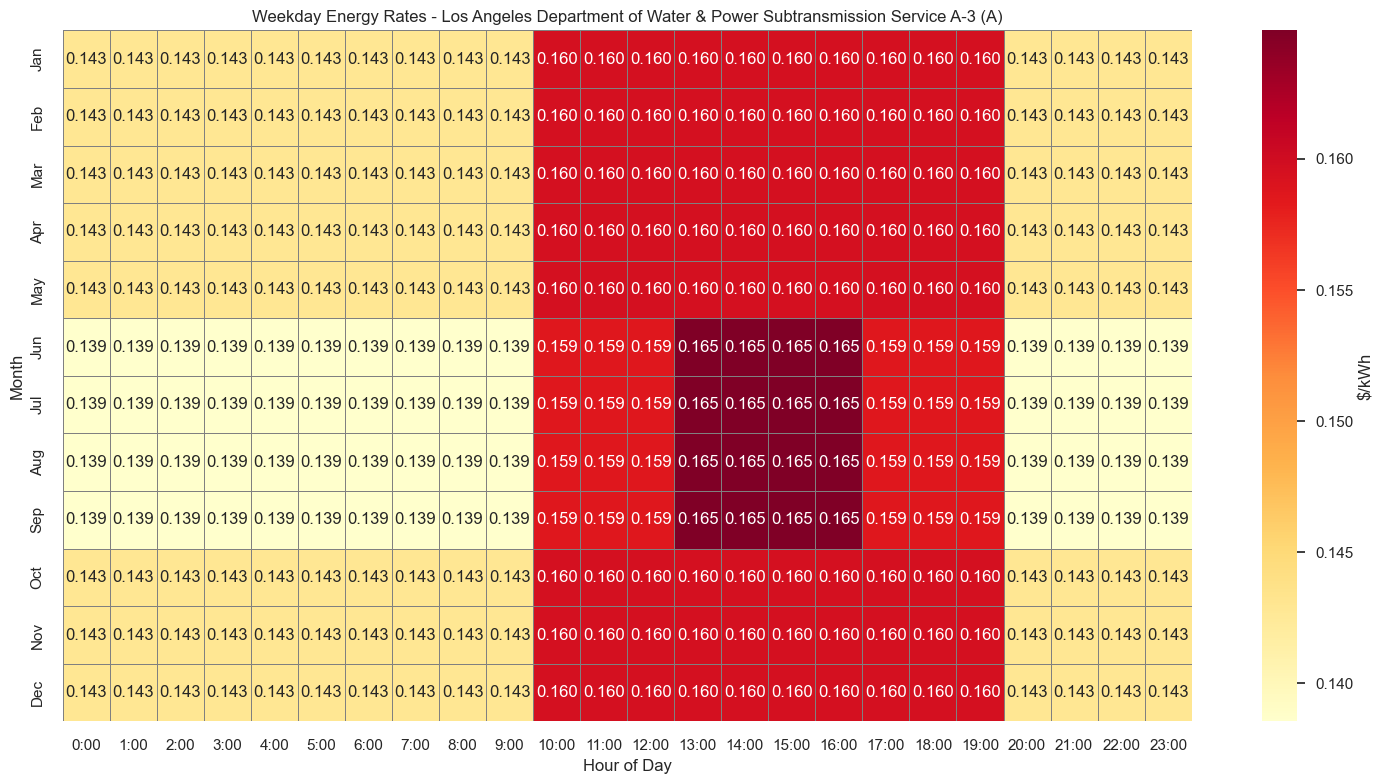

In [6]:
# Create weekday heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(weekday_df, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=[f'{h}:00' for h in hours],
            yticklabels=months,
            cbar_kws={'label': '$/kWh'},
            linewidths=0.5, linecolor='gray')  # Add gridlines
plt.title(f'Weekday Energy Rates - {utility_name} {rate_name}')
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

## Create Weekend Rate Visualization

Create a heatmap showing the energy rates by hour and month for weekends:

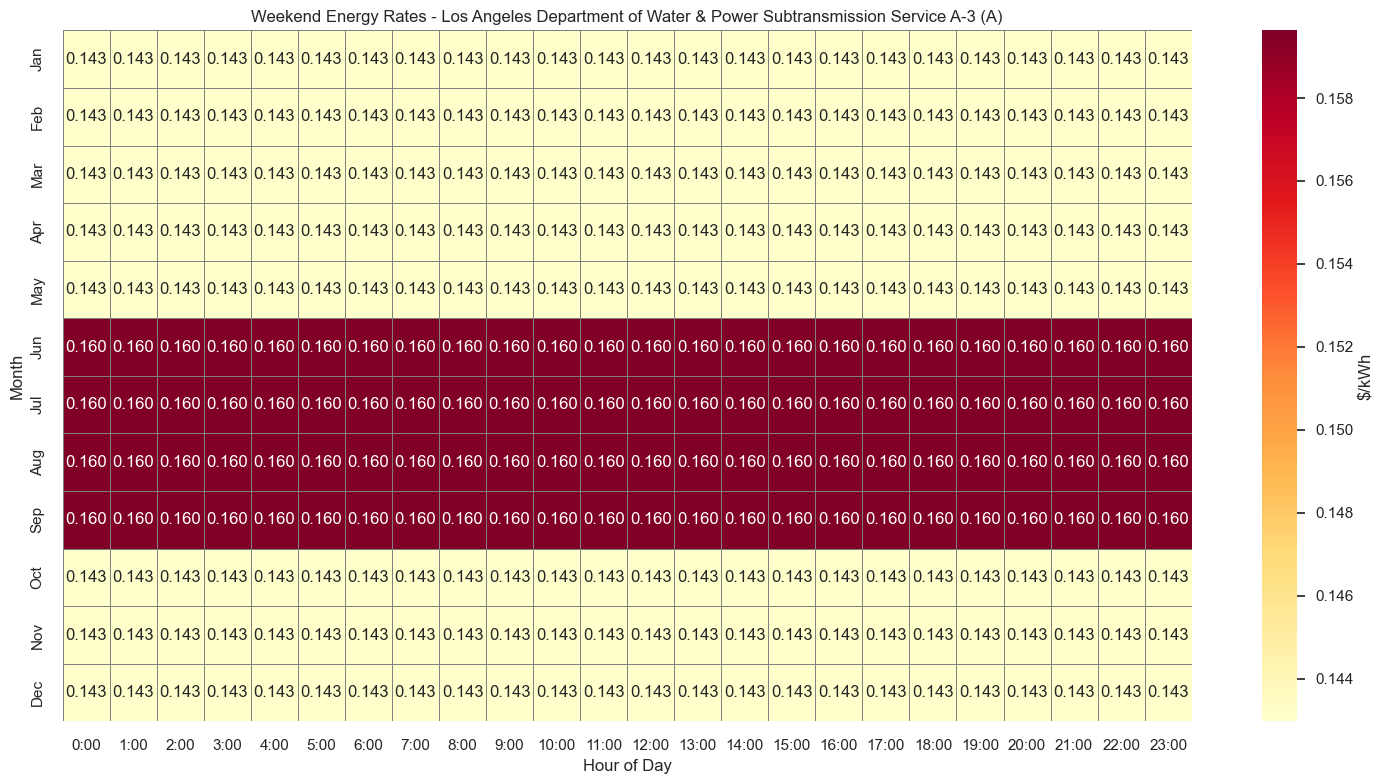

In [7]:
# Create weekend heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(weekend_df, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[f'{h}:00' for h in hours],
            yticklabels=months,
            cbar_kws={'label': '$/kWh'},
            linewidths=0.5, linecolor='gray')  # Add gridlines
plt.title(f'Weekend Energy Rates - {utility_name} {rate_name}')
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

## Display Tariff Details

Show the key information about this tariff including utility name, rate name, demand charges, and fixed charges:

In [8]:
# Create a formatted HTML table with tariff details
details = f"""
<table style="width:100%">
    <tr>
        <th colspan="2" style="text-align:left; background-color:#f0f0f0; padding:10px">Tariff Information</th>
    </tr>
    <tr>
        <td style="width:30%; padding:5px"><b>Utility Name:</b></td>
        <td style="padding:5px">{utility_name}</td>
    </tr>
    <tr>
        <td style="padding:5px"><b>Rate Name:</b></td>
        <td style="padding:5px">{rate_name}</td>
    </tr>
    <tr>
        <td style="padding:5px"><b>Sector:</b></td>
        <td style="padding:5px">{sector}</td>
    </tr>
    <tr>
        <td style="padding:5px"><b>Minimum Demand:</b></td>
        <td style="padding:5px">{tariff.get('peakkwcapacitymin', 'N/A')} kW</td>
    </tr>
    <tr>
        <td style="padding:5px"><b>Fixed Monthly Charge:</b></td>
        <td style="padding:5px">${tariff.get('fixedchargefirstmeter', 'N/A')}</td>
    </tr>
</table>

<table style="width:100%; margin-top:20px">
    <tr>
        <th colspan="2" style="text-align:left; background-color:#f0f0f0; padding:10px">Description</th>
    </tr>
    <tr>
        <td style="padding:5px">{description}</td>
    </tr>
</table>
"""

display(HTML(details))